In [1]:
import base64
import boto3
import json
from PIL import Image

modelId = "us.amazon.nova-premier-v1:0"
accept = "application/json"
contentType = "application/json"
bedrock_rt = boto3.client("bedrock-runtime", region_name="us-east-1") 

def encode_image(image_path):
    global width, height
    with Image.open(image_path) as img:  # PIL의 Image로 이미지 열기
        width, height = img.size         # 이미지 크기 가져오기
        print(width, height)
        img.show()
        # RGBA에서 RGB로 변환 (투명도 제거)
        if img.mode in ('RGBA', 'LA'):
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[-1])
            img = background
            
        # 이미지를 바이트로 변환하고 base64로 인코딩
        with open(image_path, 'rb') as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

def get_completion(messages):
    prompt_config = {
        "schemaVersion": "messages-v1",
        "inferenceConfig": {
            "max_new_tokens": 2048,
            "top_p": 0.9,
            "top_k": 20,
            "temperature": 0.1,
        },
        "messages": messages
    }
    body = json.dumps(prompt_config)
    response = bedrock_rt.invoke_model(
        body=body, modelId=modelId
    )
    response_body = json.loads(response["body"].read())
    results = response_body["output"]["message"]["content"][0]["text"]
    return results

1200 664


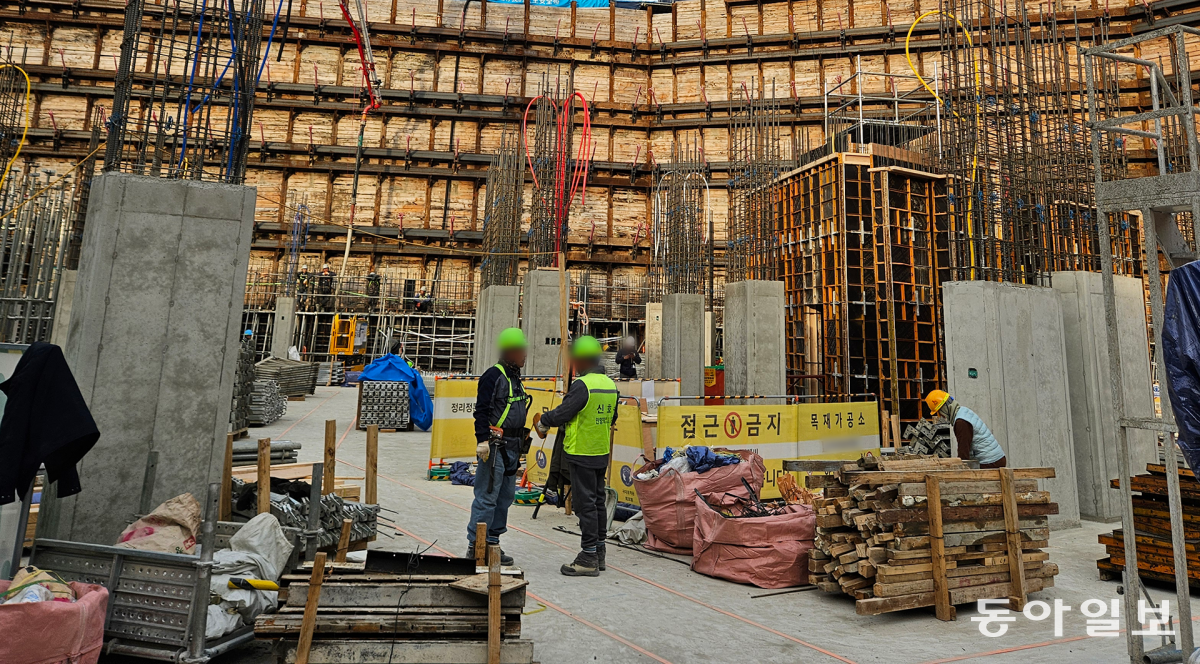

이미지 내에는 총 세 명의 사람이 존재합니다. 각 사람의 위치를 바운딩 박스의 좌표로 표시하면 다음과 같습니다:

1. 첫 번째 사람 (왼쪽에서 두 번째): (390, 501, 444, 735)
2. 두 번째 사람 (왼쪽에서 세 번째): (448, 505, 518, 760)
3. 세 번째 사람 (오른쪽에서 첫 번째): (769, 567, 837, 652)

이미지 내의 다른 요소들은 건설 현장의 일반적인 특징들을 보여주고 있으며, 건설 자재와 장비들이 보입니다.


In [2]:
# Prepare the image
image_path = "./images/detection1.png"
base64_image = encode_image(image_path)

messages = [
    {
        "role": 'user',
        "content": [
            {
                "image": {
                    "format": "png",
                    "source": {"bytes": base64_image},
                }
            },        
            {
                "text": f"이미지 내에 존재하는 사람이 총 몇명인지, 각 사람의 위치를 표시하는 바운딩 박스의 좌표를 픽셀값으로 (왼쪽 상단 x 값, 왼쪽 상단 y값, 오른쪽 하단 x값, 왼쪽 하단 y값)의 형태로 표시해줘."
            }
        ]
    }
]

result_prompt = get_completion(messages)
print(result_prompt)

In [3]:
import re

# 정규표현식을 사용하여 좌표 추출
pattern = r'\(([\d]+),\s*([\d]+),\s*([\d]+),\s*([\d]+)\)'
coordinates = re.findall(pattern, result_prompt)

# 좌표를 정수형 튜플로 변환 (스케일링 없이 직접 변환)
bounding_boxes = [(int(x1), int(y1), int(x2), int(y2)) for x1, y1, x2, y2 in coordinates]

print("추출된 바운딩 박스 좌표:")
for i, bbox in enumerate(bounding_boxes):
    print(f"사람 {i+1}: {bbox}")

추출된 바운딩 박스 좌표:
사람 1: (390, 501, 444, 735)
사람 2: (448, 505, 518, 760)
사람 3: (769, 567, 837, 652)


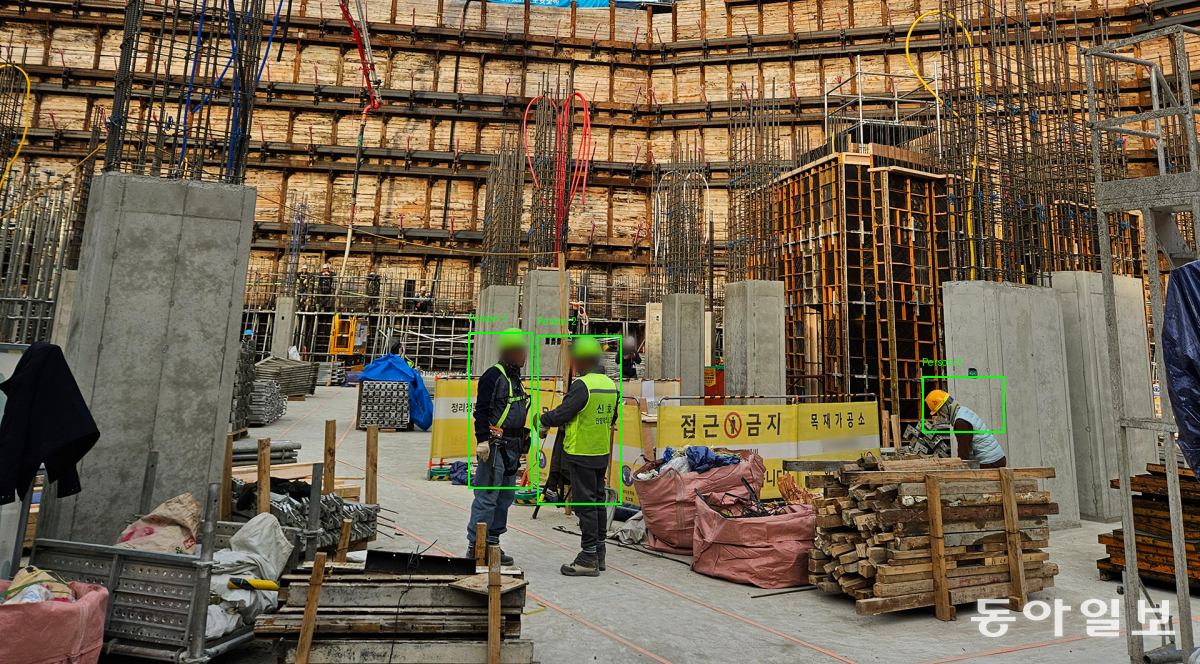

In [4]:
from PIL import Image, ImageDraw, ImageFont

# 이미지 로드
image_path = "./images/detection1.png"
image = Image.open(image_path)
draw = ImageDraw.Draw(image)

# 각 바운딩 박스 그리기
for i, bbox in enumerate(bounding_boxes):
    # 좌표 스케일링
    x1 = int(bbox[0] / 1000 * width)
    y1 = int(bbox[1] / 1000 * height)
    x2 = int(bbox[2] / 1000 * width)
    y2 = int(bbox[3] / 1000 * height)
    
    # 바운딩 박스 그리기 (초록색)
    draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=2)
    # 박스 위에 텍스트 그리기
    draw.text((x1, y1-20), f"Person {i+1}", fill=(0, 255, 0))

# 결과 이미지 저장
image.save("result_with_bbox.png")

# 결과 이미지 보여주기
image.show()

640 504


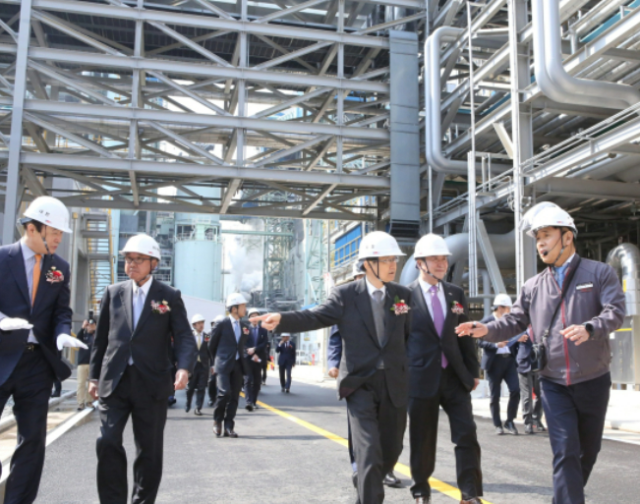

이미지 내에는 총 11명의 사람이 존재합니다. 각 사람의 위치를 표시하는 바운딩 박스의 좌표는 다음과 같습니다:

1. (0, 387, 141, 998)
2. (128, 458, 302, 998)
3. (289, 601, 333, 816)
4. (326, 575, 403, 870)
5. (396, 601, 432, 791)
6. (424, 645, 466, 782)
7. (402, 453, 655, 998)
8. (636, 458, 758, 998)
9. (707, 397, 980, 998)
10. (751, 575, 810, 865)
11. (810, 622, 855, 860)

이미지 내 모든 사람들은 안전모를 착용하고 있으며, 산업 시설 내부를 견학하는 것으로 보입니다. 배경에는 대형 구조물과 파이프라인이 보이며, 공장 내부의 복잡한 설비를 확인할 수 있습니다.


In [5]:
# Prepare the image
image_path = "./images/test.png"
base64_image = encode_image(image_path)

messages = [
    {
        "role": 'user',
        "content": [
            {
                "image": {
                    "format": "png",
                    "source": {"bytes": base64_image},
                }
            },        
            {
                "text": f"이미지 내에 존재하는 사람이 총 몇명인지, 각 사람의 위치를 표시하는 바운딩 박스의 좌표를 픽셀값으로 (왼쪽 상단 x 값, 왼쪽 상단 y값, 오른쪽 하단 x값, 왼쪽 하단 y값)의 형태로 표시해줘."
            }
        ]
    }
]

result_prompt = get_completion(messages)
print(result_prompt)

In [6]:
import re

# 정규표현식을 사용하여 좌표 추출
pattern = r'\(([\d]+),\s*([\d]+),\s*([\d]+),\s*([\d]+)\)'
coordinates = re.findall(pattern, result_prompt)

# 좌표를 정수형 튜플로 변환 (스케일링 없이 직접 변환)
bounding_boxes = [(int(x1), int(y1), int(x2), int(y2)) for x1, y1, x2, y2 in coordinates]

print("추출된 바운딩 박스 좌표:")
for i, bbox in enumerate(bounding_boxes):
    print(f"사람 {i+1}: {bbox}")

추출된 바운딩 박스 좌표:
사람 1: (0, 387, 141, 998)
사람 2: (128, 458, 302, 998)
사람 3: (289, 601, 333, 816)
사람 4: (326, 575, 403, 870)
사람 5: (396, 601, 432, 791)
사람 6: (424, 645, 466, 782)
사람 7: (402, 453, 655, 998)
사람 8: (636, 458, 758, 998)
사람 9: (707, 397, 980, 998)
사람 10: (751, 575, 810, 865)
사람 11: (810, 622, 855, 860)


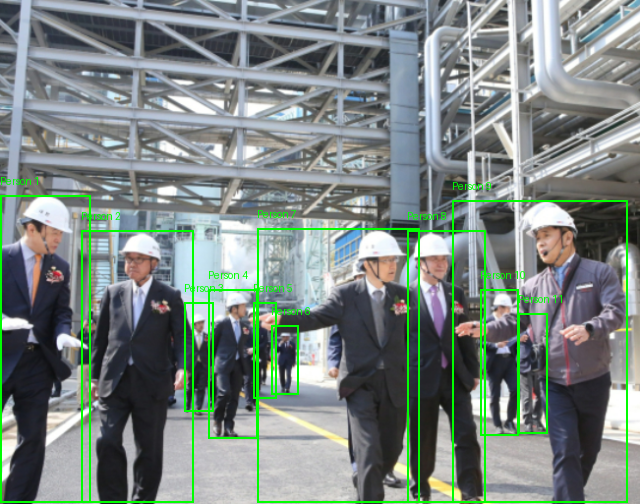

In [7]:
from PIL import Image, ImageDraw, ImageFont

# 이미지 로드
image_path = "./images/test.png"
image = Image.open(image_path)
draw = ImageDraw.Draw(image)

# 각 바운딩 박스 그리기
for i, bbox in enumerate(bounding_boxes):
    # 좌표 스케일링
    x1 = int(bbox[0] / 1000 * width)
    y1 = int(bbox[1] / 1000 * height)
    x2 = int(bbox[2] / 1000 * width)
    y2 = int(bbox[3] / 1000 * height)
    
    # 바운딩 박스 그리기 (초록색)
    draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=2)
    # 박스 위에 텍스트 그리기
    draw.text((x1, y1-20), f"Person {i+1}", fill=(0, 255, 0))

# 결과 이미지 저장
image.save("result_with_bbox.png")

# 결과 이미지 보여주기
image.show()

500 334


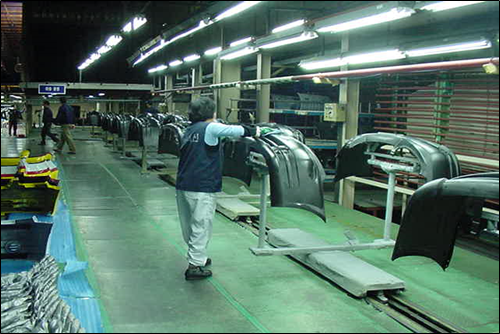

이미지 내에는 총 4명의 사람이 존재합니다. 각 사람의 위치를 바운딩 박스의 좌표로 표시하면 다음과 같습니다:

1. 첫 번째 사람: (303, 290, 466, 847)
2. 두 번째 사람: (102, 294, 146, 464)
3. 세 번째 사람: (72, 300, 110, 447)
4. 네 번째 사람: (17, 322, 39, 414)

이미지 내 작업자는 자동차 부품을 조립하는 작업을 하고 있으며, 다른 사람들은 공장 내 다른 위치에서 작업 또는 이동 중인 것으로 보입니다.


In [8]:
# Prepare the image
image_path = "./images/test1.png"
base64_image = encode_image(image_path)

messages = [
    {
        "role": 'user',
        "content": [
            {
                "image": {
                    "format": "png",
                    "source": {"bytes": base64_image},
                }
            },        
            {
                "text": f"이미지 내에 존재하는 사람이 총 몇명인지, 각 사람의 위치를 표시하는 바운딩 박스의 좌표를 픽셀값으로 (왼쪽 상단 x 값, 왼쪽 상단 y값, 오른쪽 하단 x값, 왼쪽 하단 y값)의 형태로 표시해줘."
            }
        ]
    }
]

result_prompt = get_completion(messages)
print(result_prompt)

In [9]:
import re

# 정규표현식을 사용하여 좌표 추출
pattern = r'\(([\d]+),\s*([\d]+),\s*([\d]+),\s*([\d]+)\)'
coordinates = re.findall(pattern, result_prompt)

# 좌표를 정수형 튜플로 변환 (스케일링 없이 직접 변환)
bounding_boxes = [(int(x1), int(y1), int(x2), int(y2)) for x1, y1, x2, y2 in coordinates]

print("추출된 바운딩 박스 좌표:")
for i, bbox in enumerate(bounding_boxes):
    print(f"사람 {i+1}: {bbox}")

추출된 바운딩 박스 좌표:
사람 1: (303, 290, 466, 847)
사람 2: (102, 294, 146, 464)
사람 3: (72, 300, 110, 447)
사람 4: (17, 322, 39, 414)


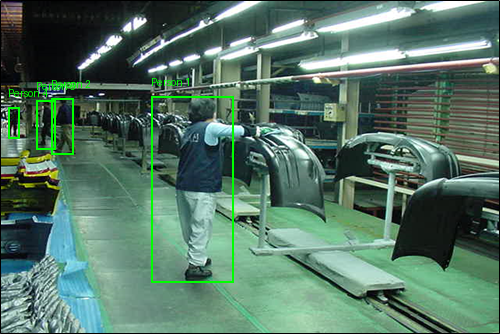

In [10]:
from PIL import Image, ImageDraw, ImageFont

# 이미지 로드
image_path = "./images/test1.png"
image = Image.open(image_path)
draw = ImageDraw.Draw(image)

# 각 바운딩 박스 그리기
for i, bbox in enumerate(bounding_boxes):
    # 좌표 스케일링
    x1 = int(bbox[0] / 1000 * width)
    y1 = int(bbox[1] / 1000 * height)
    x2 = int(bbox[2] / 1000 * width)
    y2 = int(bbox[3] / 1000 * height)
    
    # 바운딩 박스 그리기 (초록색)
    draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=2)
    # 박스 위에 텍스트 그리기
    draw.text((x1, y1-20), f"Person {i+1}", fill=(0, 255, 0))

# 결과 이미지 저장
image.save("result_with_bbox.png")

# 결과 이미지 보여주기
image.show()